In [1]:
from pathlib import Path
from typing import List
from typing import Tuple
from typing import Union

import faiss
import imagehash
import numpy as np
from PIL import Image
from PIL.Image import Image as PILImage

from utils import ImageLoader

DATA_DIR = Path().resolve() / "data"
IMAGE_DIR = DATA_DIR / "images"
INDEX_PATH = DATA_DIR / "faiss_imagehash.index"
IDS_PATH = DATA_DIR / "faiss_imagehash.ids"

In [2]:

class ImageHashVectorizer:

    @staticmethod
    def vectorize(image: PILImage) -> np.ndarray:

        return np.float32(imagehash.phash(image).hash.reshape(1, 64))


In [3]:

class FaissImageHashImageSearchEngine:

    def __init__(
        self,
        index_path: Path = INDEX_PATH,
        ids_path: Path = IDS_PATH,
        vectorizer: ImageHashVectorizer = ImageHashVectorizer(),
    ):

        self.index_path = index_path
        self.ids_path = ids_path
        self.vectorizer = vectorizer

        self.index: Optional[faiss.Index] = None
        self.ids: Optional[List[str]] = None

        self.__init_index()
        self.__init_ids()

    def __init_index(self):

        if self.index_path.exists():
            self.index = faiss.read_index(str(self.index_path))
        else:
            # Meaning of args and attrs: https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#indexhnsw-variants
            self.index = faiss.IndexHNSWFlat(64, 48)

        self.index.hnsw.efConstruction = 128  # dafault: 40
        self.index.hnsw.efSearch = 256        # default: 16

    def __init_ids(self):

        if self.ids_path.exists():
            with self.ids_path.open() as f:
                self.ids = [
                    line.strip()
                    for line in f.readlines() if line not in ("", "\n")
                ]
        else:
            self.ids = []

    def update(self, targets: Union[str, Path]):

        ids_cache = set(self.ids)

        for target in targets:

            if target in ids_cache:
                continue

            image = ImageLoader.load(target)
            if not image:
                continue

            vector = self.vectorizer.vectorize(image)

            if self.index.ntotal > 0:
                distances, indices = self.index.search(vector, 1)
                if distances[0] == 0:
                    continue

            self.index.add(vector)
            self.ids.append(target)
            ids_cache.add(target)

    def save(self):

        faiss.write_index(self.index, str(self.index_path))
        with self.ids_path.open("w") as f:
            f.write("\n".join(self.ids))

    def search(
        self,
        target: Union[str, Path],
        k: int = 10,
    ) -> Tuple[np.ndarray, List[str]]:

        image = ImageLoader.load(target)
        if not image:
            return np.array([]), []

        vector = self.vectorizer.vectorize(image)
        distances, indices = self.index.search(vector, k)

        return distances[0], [self.ids[i] if i > -1 else "" for i in indices[0]]


In [4]:
search_engine = FaissImageHashImageSearchEngine()
search_engine.update(list(map(str, IMAGE_DIR.glob("*.jpg"))))
search_engine.save()

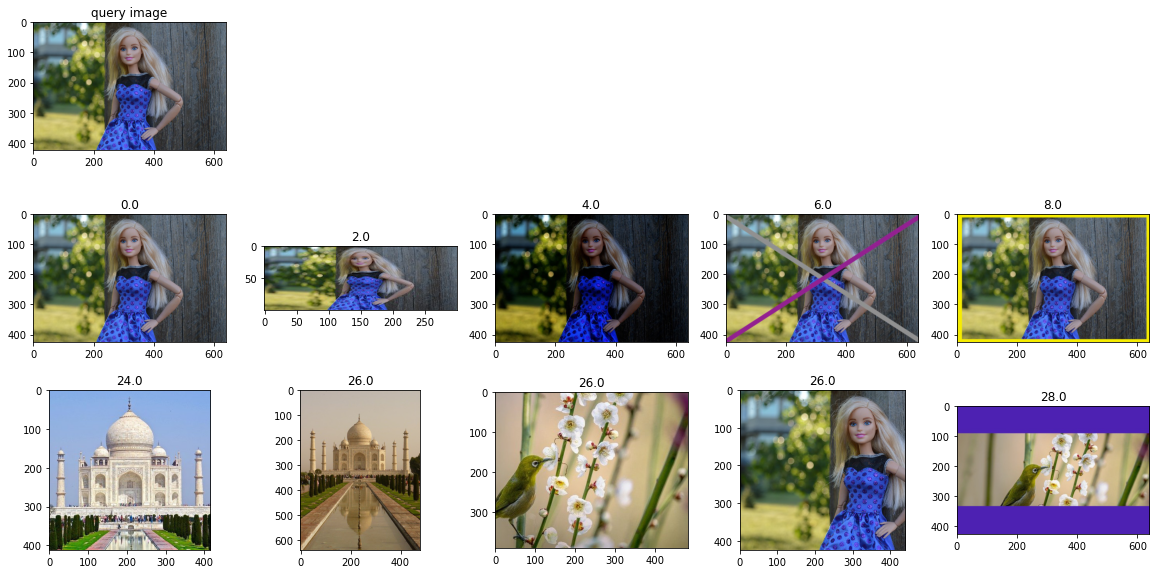

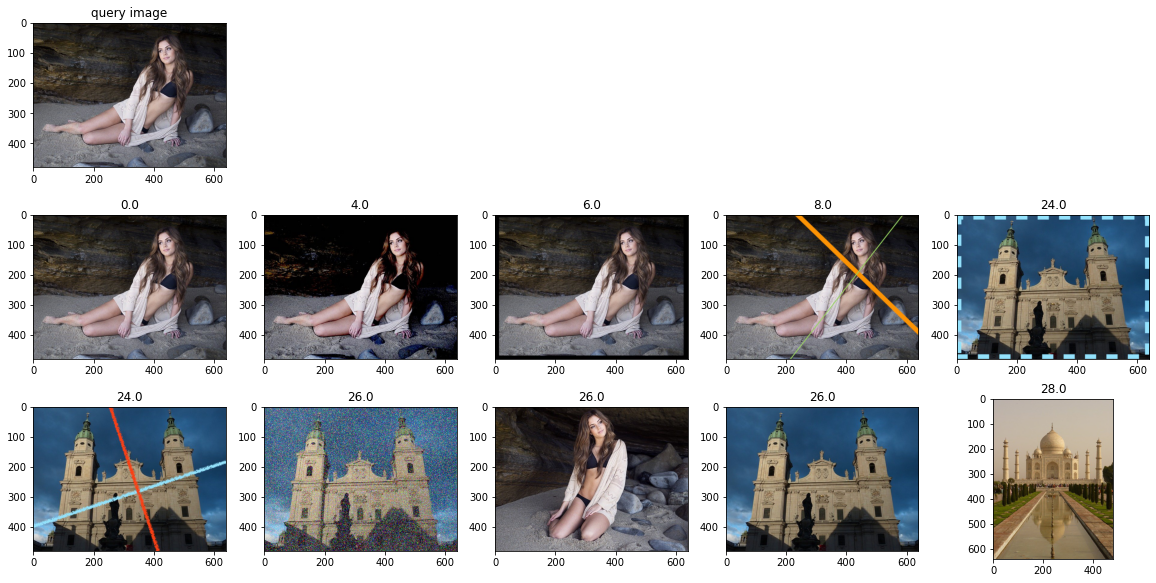

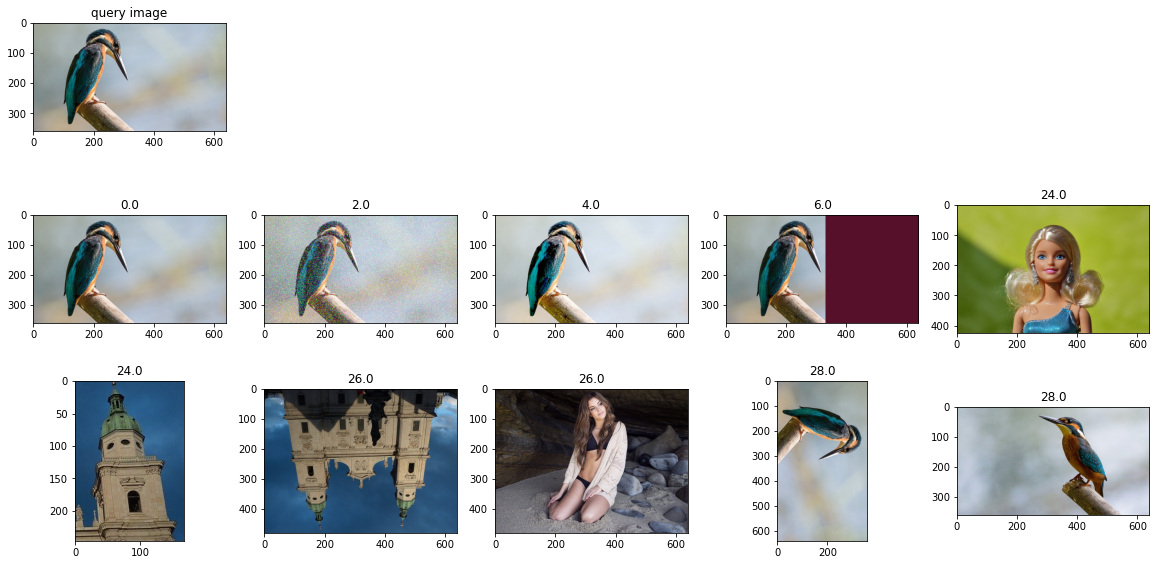

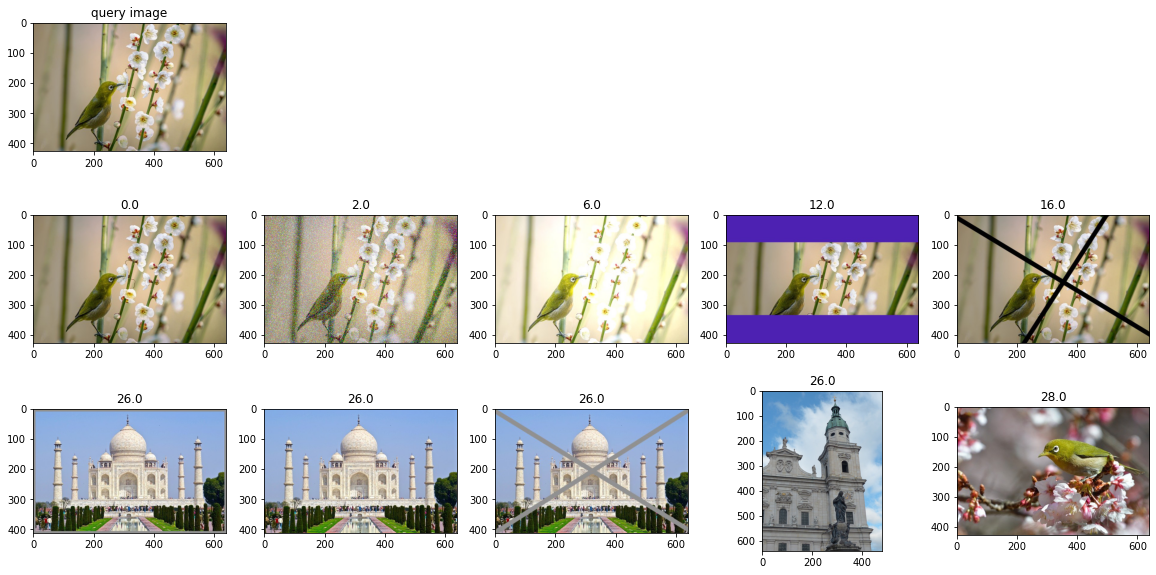

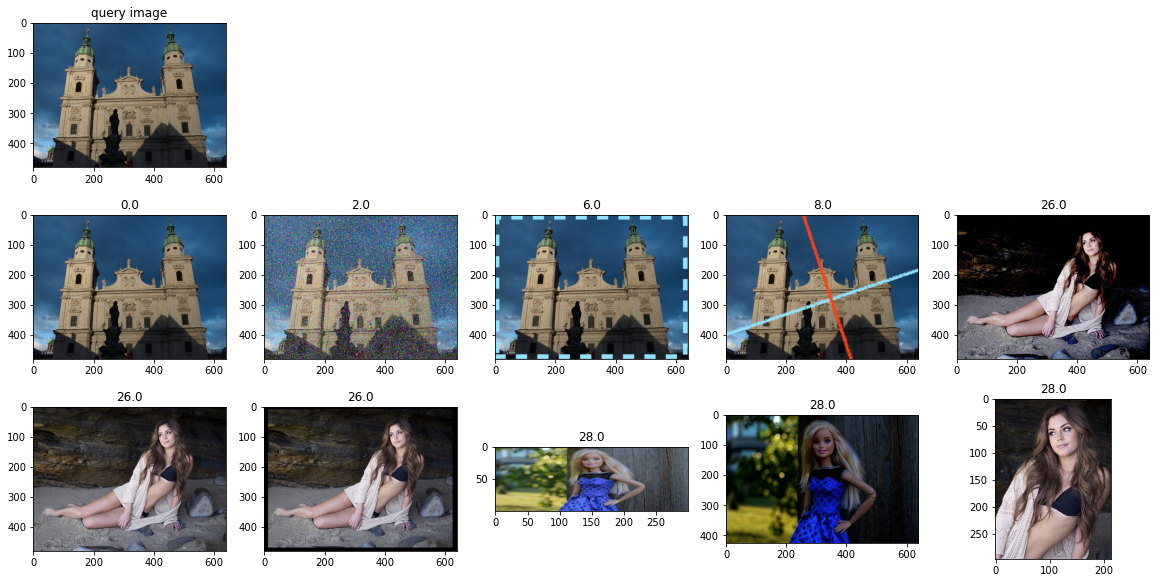

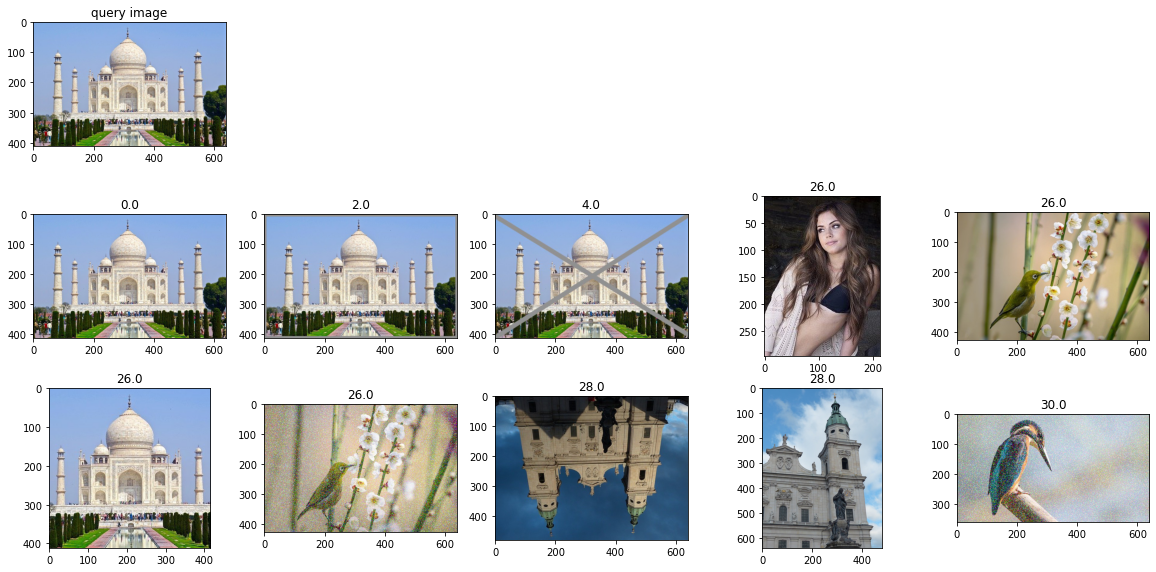

In [5]:
from matplotlib import pyplot as plt

query_images = [
    '/opt/notebooks/data/images/barbie-1565718_640.jpg',
    '/opt/notebooks/data/images/beautiful-1274064_640.jpg',
    '/opt/notebooks/data/images/kingfisher-881975_640.jpg',
    '/opt/notebooks/data/images/little-bird-6036530_640.jpg',
    '/opt/notebooks/data/images/salzburg-cathedral-122777_640.jpg',
    '/opt/notebooks/data/images/taj-mahal-866692_640.jpg',
]

for query_image in query_images:

    distances, indices = search_engine.search(query_image)
    plt.figure(figsize=(20,10))
    plt.subplot(3, 5, 1)
    plt.title("query image")
    plt.imshow(Image.open(query_image))
    for i, index_image in enumerate(indices):
        plt.subplot(3, 5, 6 + i)
        plt.imshow(Image.open(index_image))
        plt.title(distances[i])

In [6]:
import random
import timeit

timeit.timeit("search_engine.search(random.choice(query_images))", number=100, globals=globals())

2.6249043000134407